In [1]:
import numpy as  np

from abc import ABC, abstractmethod



In [2]:
class FreeEnergy(ABC):

    @abstractmethod
    def energy(self):
        pass

In [3]:
class IdealGibbs(FreeEnergy):
    '''calculate the ideal solution gibbs free energy, takes x as a parameter
'''
    def __init__(self,omega=0):
        
        # set the non-deality parameter
        self.omega = omega  
    
    def energy(self,T,x):
        '''
            Evaluate Free Energy of the nearly ideal liqud
            given by 
            # unitless
            G/(RT_c) = T^ (xln(x) + (1-x)ln(x) + omega*x*(1-x))
        '''
        return  T * (x*np.log(x) + (1-x)*np.log(x) + self.omega*x*(1-x)) 
    
    
    def opt_x(self,T):
        '''Find the optimal value(s) of x for a given temperature'''
        
        pass

In [4]:
coef_test = np.array([[0,2,4], 
                      [1,3,0],
                      [5,0,0]])


c=coef_test
x=12
y=12
c[1,0]*x+c[0,1]*y+ c[1,1]*x*y+c[0,2]*y**2+c[2,0]*x**2

1764

In [5]:
from numpy.polynomial import Polynomial
from numpy.polynomial.polynomial import polyval2d,polyvander2d

import numpy.polynomial.polynomial as poly 


print(polyval2d(x,y, coef_test))

print(polyvander2d(x,y,[2,2]))



class Poly2D:
    def __init__(self,c):
        
        if len(c.shape) == 2:
            self.coef = c
            self.c = self.coef
        else:
            raise ValueError('Polynomial coefficients need to be a 2d array')
        
    def val(self,x,y,**kwargs):
        return poly.polyval2d(x,y,self.coef,**kwargs)
    
    def deriv(self,m=1,scl=1,axis=0):
        '''
            m : int, optional
                order of differntiation
            scl : scalar, optional
                scaling factor
            axis : int
                index of axis of differntiation
        '''
        return Poly2D(poly.polyder(self.coef,m=m,scl=scl,axis=axis))
    
    def integ(self,m=1, k=[], lbnd=0, scl=1, axis=0):
        '''
            m : int, optional
                Integrate this many times
            k : array_like, optional
                constants of integration
            axis = axis of integration
        '''
        
        return Poly2D(poly.polyint(self,m=m,k=k,lbnd=lbnd,scl=scl,axis=axis))
    
    def grid(self,x,y):
        return poly.polygrid2d(x,y,self.coef)
    
    def __call__(self,x,y):
        return self.val(x,y)
    def __repr__(self):
        return '\n'.join(['2D - Polynomial with coefficients: ', self.coef.__repr__()])
    
    ## Multiplying and adding not implemented
    def __add__(self,other):
        
        return Poly2D(self.coef+other.coef)
    def __sub__(self,other):
        return Poly2D(self.coef-other.coef)
    def __mul__(self,other):
        raise NotImplementedError('2D polynomial multiplication not implemented')
        #return Poly2D(poly.polymul(self.coef,other.coef))
    def __div__(self,other):
        raise NotImplementedError('2D polynomial division not implemented')

        #return #Poly2D(poly.polydiv(self.coef,other.coef))

1764.0
[[1.0000e+00 1.2000e+01 1.4400e+02 1.2000e+01 1.4400e+02 1.7280e+03
  1.4400e+02 1.7280e+03 2.0736e+04]]


In [6]:
Polynomial([1,2,3]).integ
Poly2D(coef_test) + Poly2D(coef_test) 




2D - Polynomial with coefficients: 
array([[ 0,  4,  8],
       [ 2,  6,  0],
       [10,  0,  0]])

In [7]:
x = np.linspace(0,100,1000)
y = np.linspace(-50,50,250)
Z = Poly2D(coef_test).grid(x,y)

X,Y = np.meshgrid(x,y)



In [8]:
# from mpl_toolkits import mplot3d

# import matplotlib as mpl
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = plt.axes(projection='3d')

# ax.plot_surface(X,Y,Z.T)

In [9]:

class BMixingGibbs(IdealGibbs):
    def __init__(self,G_BA,omega):
        # pass the value of omega to the level above
        super().__init__(omega)
        self.G_BA = G_BA # assign the coefficient for G_BA
        
    def energy(self,T,x):
        ''' As with ideal depends only on the free energy of the the above'''
        
        return self.G_BA * x + super().energy(T,x)
    def x_equib(self,T):
        raise NotImplementedError
    
class FinalMixingGibbs(FreeEnergy):
    '''composes a BMixingGibbs object calculates G_BA on the fly?? - depends on pressure'''
    
    def __init__(self,poly_B:Poly2D,omega_func,Tc,Pc):
        '''
                poly_B = the polynomial form for the G_BA coefficient. 2d polynomial
                
                omega_func : function of T and deltaP, dimensionless, that gives omega
                
                Dimensionless:
                Tc : float
                    Critical temperature for l-l transiotn
                Pc : float
                    critical pressure for l-l transiton
                

        '''

        self.poly_B = poly_B

        self.omega_func = omega_func
        self.Pc = Pc
        self.Tc = Tc
            
    def energy(self,T,P):
        '''
            evaluate the temperature and pressure of the free energy
        '''
        
        deltaT  = T - self.Tc
        deltaP  = P-self.Pc
        
        ## initialise BMixingGibbs object with G_ba and omega
        
        bmixer = self.make_bmixer(T,P)
       
        
        x = bmixer.x_equib(T,p)
        
        return bmixer.energy


    def x_equib(self,T,P):

        return make_bmixer(T,P).x_equib(T)

    def make_bmixer(self,T,P) -> BMixingGibbs:
        G_BA = self.poly_B(deltaT,deltaP)
        omega = self.omega_func(T,deltaP)
        bmixer = BMixingGibbs(G_BA,omega) 
        return bmixer

In [10]:
class TSEOSFreeEnergy(FreeEnergy):

    def energy(self):
        pass
    pass

In [11]:
TSEOSFreeEnergy()

In [12]:
#left_f = lambda x :

G = +5 # G_BA/RT
Tc = 182 # K
Pc = 11700 # bar
rhoc=1.017e6/(15.994+2*1.008) #mol m^-3
R = 8.314 # J K^-1 mol^ -1

delP = (1-1700)/(rhoc*Tc*R)
T=900/182 
w_0 = 0.03
w = (2 +w_0*delP)/T
print(w)

the_f_to_min = lambda x :  np.log(x/1-x)  + G + w*(1-2*x)   

the_f = lambda x : x*G + (x*np.log(x)+(1-x)*np.log(1-x)+w*x*(1-x))   #G/RT

0.4044443238145733


In [13]:
from scipy.optimize import fsolve

In [14]:
import matplotlib.pyplot as plt

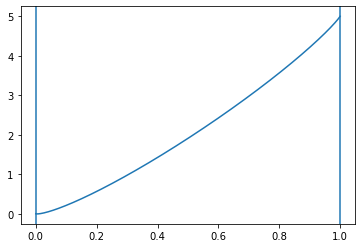

In [15]:
x = np.linspace(0.0001,0.9999,1000)

plt.plot(x,the_f(x))
plt.axvline(0)
plt.axvline(1)

In [16]:
the_grad = lambda x : np.gradient(the_f(x),x)

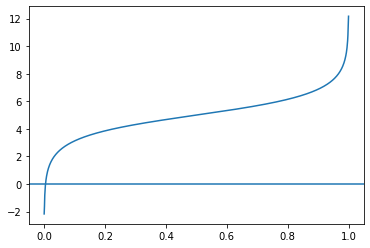

In [17]:
plt. plot(x, the_grad(x))
plt. axhline(0)

In [18]:
from gibbs import Bib

ImportError: cannot import name 'Bibble' from 'gibbs' (/home/aidan/my_gits/ts_eos/gibbs.py)